In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

In [2]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [3]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [4]:
directory = '../data/'
df_empresas = pd.read_csv(directory + "grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2019-2020..csv", sep=";", encoding="ISO-8859-1")
df_empresas["normalised_date"]= pd.to_datetime(df_empresas["normalised_date"]) 
df_empresas = df_empresas.rename(columns={"sentiment": "sentiment_empresas"})

df = pd.read_csv(directory + "stocks_and_sentiment_2020.csv", sep=";", names=['date','sentiment','price'], encoding="ISO-8859-1")
df["date"]= pd.to_datetime(df["date"]) 
df = df.rename(columns={"sentiment": "sentiment_asoc"})

df = df_empresas.merge(df, left_on="normalised_date", right_on="date")
df = df[["sentiment_empresas", "sentiment_asoc", "price"]]
df.head()

,sentiment_empresas,sentiment_asoc,price
0,0.243997,0.219692,-0.169729
1,0.185506,0.214739,0.262752
2,0.130081,0.247731,0.298582
3,0.141136,0.232923,0.320586
4,0.156070,0.284574,0.642212


In [12]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_peru-2016-2020.csv"
filename_empresas ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2017-2020.csv"
filename_precios_bolsa = "../data/pe_bvl_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_empresas = pd.read_csv(filename_empresas, sep=";")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_total = pd.merge(left=df_asoc, right=df_empresas, left_on='normalised_date', right_on='normalised_date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_empresas"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_empresas"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_empresas = df_total.sentiment_empresas.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"price_change": "peru_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_empresas'] = df_total['sentiment_empresas'].astype(float)
df_total['peru_change'] = df_total['peru_change'].astype(float)


df_total = df_total[:-110]
df_total

,normalised_date,sentiment_asociacones,sentiment_empresas,date,peru_change
1,2017-03-01,-0.015294,0.105405,2017-03-01,-1.242825
2,2017-03-02,-0.049415,-0.051242,2017-03-02,-0.395745
3,2017-03-03,0.162448,0.090944,2017-03-03,-2.106603
4,2017-03-06,-0.041206,-0.154455,2017-03-06,-0.668194
5,2017-03-07,-0.058503,0.095434,2017-03-07,-0.817405
...,...,...,...,...,...
701,2019-12-13,-0.026186,0.034577,2019-12-13,-0.012458
702,2019-12-16,0.084129,0.066679,2019-12-16,0.656283
703,2019-12-17,0.025995,-0.028741,2019-12-17,1.063245
704,2019-12-18,-0.006070,0.006991,2019-12-18,0.987035


In [13]:


from sklearn.preprocessing import MinMaxScaler

#X = scaler.fit_transform(df_diff.values)
#X_sent_asoc = X[:,0][:-future_steps]
#X_prices = X[:,1][:-future_steps]
#X_prices_next = X[:,1]


#plt.plot(X)

num_steps = 7
future_steps = 1

X_sent_asoc = df_total.sentiment_asociacones.values[:-future_steps]
X_sent_empresas = df_total.sentiment_empresas.values[:-future_steps]
X_prices = df_total.peru_change.values[:-future_steps]
X_prices_next = df_total.peru_change.values

'''
scaler = MinMaxScaler(feature_range=(1, 2))
scaler = scaler.fit(df_total[["peru_change", "sentiment_empresas","sentiment_asociacones"]].values.reshape(-1,1))

shape = X_sent_asoc.shape
X_sent_asoc = X_sent_asoc.reshape(-1,1)
X_sent_asoc = scaler.transform(X_sent_asoc)
X_sent_asoc = X_sent_asoc.reshape(shape)

X_sent_empresas = X_sent_empresas.reshape(-1,1)
X_sent_empresas = scaler.transform(X_sent_empresas)
X_sent_empresas = X_sent_empresas.reshape(shape)

X_prices = X_prices.reshape(-1,1)
X_prices = scaler.transform(X_prices)
X_prices = X_prices.reshape(shape)

shape = X_prices_next.shape
X_prices_next = X_prices_next.reshape(-1,1)
X_prices_next = scaler.transform(X_prices_next)
X_prices_next = X_prices_next.reshape(shape)
'''

X = np.array(create_window_data_arrays((X_sent_asoc,X_sent_empresas, X_prices), num_steps))
Y = create_window_data_array_with_shift(X_prices_next, future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(697, 7, 3) (697, 1)


In [14]:

train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, shuffle=False)

'''
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, random_state=1000)
'''


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_y[-10:])

(627, 7, 3) (627, 1) (70, 7, 3) (70, 1)
[[ 0.63701615]
 [ 0.28836726]
 [ 0.97759895]
 [-0.36613981]
 [ 0.41107035]
 [ 2.06217536]
 [-0.11193898]
 [-0.8760692 ]
 [ 0.12471891]
 [ 0.56891983]]


Epoch 1/150
16/16 - 0s - loss: 0.5748 - accuracy: 0.0000e+00 - val_loss: 0.5376 - val_accuracy: 0.0000e+00
Epoch 2/150
16/16 - 0s - loss: 0.5713 - accuracy: 0.0000e+00 - val_loss: 0.5374 - val_accuracy: 0.0000e+00
Epoch 3/150
16/16 - 0s - loss: 0.5688 - accuracy: 0.0000e+00 - val_loss: 0.5380 - val_accuracy: 0.0000e+00
Epoch 4/150
16/16 - 0s - loss: 0.5706 - accuracy: 0.0000e+00 - val_loss: 0.5381 - val_accuracy: 0.0000e+00
Epoch 5/150
16/16 - 0s - loss: 0.5733 - accuracy: 0.0000e+00 - val_loss: 0.5383 - val_accuracy: 0.0000e+00
Epoch 6/150
16/16 - 0s - loss: 0.5706 - accuracy: 0.0000e+00 - val_loss: 0.5385 - val_accuracy: 0.0000e+00
Epoch 7/150
16/16 - 0s - loss: 0.5707 - accuracy: 0.0000e+00 - val_loss: 0.5385 - val_accuracy: 0.0000e+00
Epoch 8/150
16/16 - 0s - loss: 0.5713 - accuracy: 0.0000e+00 - val_loss: 0.5384 - val_accuracy: 0.0000e+00
Epoch 9/150
16/16 - 0s - loss: 0.5690 - accuracy: 0.0000e+00 - val_loss: 0.5383 - val_accuracy: 0.0000e+00
Epoch 10/150
16/16 - 0s - loss: 0.570

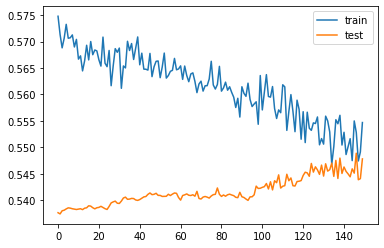

In [15]:
output_size = future_steps
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.6))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100
19/19 - 0s - loss: 0.6737 - accuracy: 0.0000e+00 - mae: 0.6737 - val_loss: 1.7264 - val_accuracy: 0.0000e+00 - val_mae: 1.7264
Epoch 2/100
19/19 - 0s - loss: 0.6039 - accuracy: 0.0000e+00 - mae: 0.6039 - val_loss: 1.7316 - val_accuracy: 0.0000e+00 - val_mae: 1.7316
Epoch 3/100
19/19 - 0s - loss: 0.5805 - accuracy: 0.0000e+00 - mae: 0.5805 - val_loss: 1.7328 - val_accuracy: 0.0000e+00 - val_mae: 1.7328
Epoch 4/100
19/19 - 0s - loss: 0.5748 - accuracy: 0.0000e+00 - mae: 0.5748 - val_loss: 1.7354 - val_accuracy: 0.0000e+00 - val_mae: 1.7354
Epoch 5/100
19/19 - 0s - loss: 0.5776 - accuracy: 0.0000e+00 - mae: 0.5776 - val_loss: 1.7326 - val_accuracy: 0.0000e+00 - val_mae: 1.7326
Epoch 6/100
19/19 - 0s - loss: 0.5719 - accuracy: 0.0000e+00 - mae: 0.5719 - val_loss: 1.7331 - val_accuracy: 0.0000e+00 - val_mae: 1.7331
Epoch 7/100
19/19 - 0s - loss: 0.5758 - accuracy: 0.0000e+00 - mae: 0.5758 - val_loss: 1.7342 - val_accuracy: 0.0000e+00 - val_mae: 1.7342
Epoch 8/100
19/19 - 0s - lo

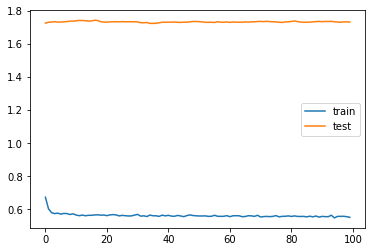

In [10]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=2,  callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

2/2 [==============================] - 0s 1ms/step
0.5477957455679361
[[ 7.16853641e-01  2.86329865e-01]
 [ 5.28432847e-01  3.49942595e-01]
 [ 1.12688212e-02  3.70703548e-01]
 [-4.89072315e-01  4.60480452e-02]
 [ 1.67330777e-01 -8.64314474e-03]
 [-3.92882306e-01  7.24966638e-03]
 [-3.28464639e-01  6.35518953e-02]
 [-6.05582165e-01  6.33904859e-02]
 [ 6.27467767e-01 -4.24329266e-02]
 [-8.77779119e-02  4.03490849e-02]
 [ 8.64349630e-01  2.46138647e-02]
 [-1.85757208e-01  1.36559695e-01]
 [-5.97952738e-01  9.24831629e-02]
 [-1.84666818e+00  8.05948973e-02]
 [-1.44729744e+00 -1.70991510e-01]
 [ 4.17834274e-01 -1.17224604e-01]
 [ 1.32411879e+00  3.11495923e-03]
 [-4.14548105e-01  1.62881181e-01]
 [-4.74931820e-01  6.58451542e-02]
 [ 2.83707072e-01  5.91850877e-02]
 [ 1.44782357e+00  4.29244861e-02]
 [ 4.20116654e-01  3.24669540e-01]
 [-2.95273148e-01  2.85504699e-01]
 [-5.35962414e-02  2.37282768e-01]
 [-6.04785768e-02  1.21751264e-01]
 [ 9.18691983e-01  1.01457186e-01]
 [-6.19677745e-01  1

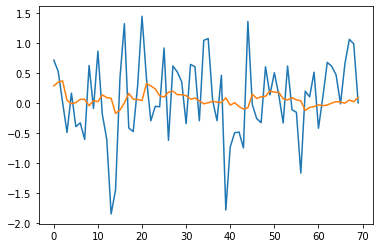

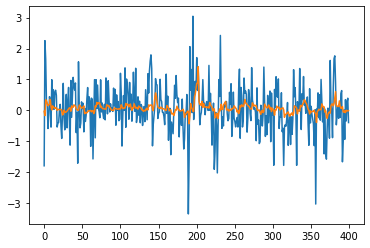

In [16]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)

print("---")

print(mean_absolute_error(Y, y_pred))
print("---")
print("---")


print(r2_score(y_pred,Y))
print(mean_absolute_percentage_error(y_pred,Y))


y_pred_test = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred_test))
print(r2_score(y_pred_test,test_y))
print(mean_absolute_percentage_error(y_pred_test,test_y))

M = np.column_stack((test_y, y_pred_test))
plot1 = plt.figure(2)
plt.plot(M)

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))

M = np.column_stack((train_y, y_pred_train))

plot1 = plt.figure(3)
plt.plot(M[:400])

plt.show()


In [28]:
def take_predecesor(y):
    y_pred = y[:-1]
    y_pred = np.insert(y_pred, 0, 0, axis=0)
    return y_pred

Y_null_model = take_predecesor(Y)

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))


[[-1.79543958  0.        ]
 [ 2.25488958 -1.79543958]
 [ 1.65729523  2.25488958]
 [ 0.29283388  1.65729523]
 [ 0.20167447  0.29283388]
 [-0.58933112  0.20167447]
 [-0.15698911 -0.58933112]
 [ 0.44178488 -0.15698911]
 [ 0.28082861  0.44178488]
 [-0.54325689  0.28082861]]
0.7790496925547731
-0.7349245538884233
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [29]:
predecesor_1 = take_predecesor(Y)
predecesor_2 = take_predecesor(predecesor_1)

Y_null_model = (predecesor_1 + predecesor_2)/2

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[-1.79543958  0.        ]
 [ 2.25488958 -0.89771979]
 [ 1.65729523  0.229725  ]
 [ 0.29283388  1.9560924 ]
 [ 0.20167447  0.97506455]
 [-0.58933112  0.24725417]
 [-0.15698911 -0.19382833]
 [ 0.44178488 -0.37316012]
 [ 0.28082861  0.14239788]
 [-0.54325689  0.36130674]]
0.6747546950741512
-1.4257203035972248
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [30]:
mean = np.mean(Y)
Y_null_model = np.full(Y.shape, mean)
np.column_stack((Y, Y_null_model))

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[-1.79543958  0.04199835]
 [ 2.25488958  0.04199835]
 [ 1.65729523  0.04199835]
 [ 0.29283388  0.04199835]
 [ 0.20167447  0.04199835]
 [-0.58933112  0.04199835]
 [-0.15698911  0.04199835]
 [ 0.44178488  0.04199835]
 [ 0.28082861  0.04199835]
 [-0.54325689  0.04199835]]
0.5680841779618132
-1.190531644575582e+34
1352.6344195106637
